In [0]:
!pip install -qU git+https://github.com/harvardnlp/pytorch-struct@fixalign
!pip install -qU git+https://github.com/harvardnlp/genbmm
!pip install -q matplotlib

In [0]:
import torch
import torch_struct
import matplotlib.pyplot as plt

In [0]:
# Character Vocab
vocab = ["a", "b", "c", "d", "e", "_"]
v_dict = { a:i for i, a in enumerate(vocab)}
L = len(vocab)

# Char sequence
letters = "a _ b _ c _ d _ e"
t = len(letters.split())

# Frame sequence
frames = ["a", "a", "a", "_", "b", "b", "c", "c", "c", "c", "_", "_", "d", "e"]

# Constants
T, B = len(frames), 5
D1, MATCH, D2 = 0, 1, 2

def show(m):
    plt.yticks(torch.arange(len(letters.split())), letters.split())
    plt.xticks(torch.arange(T), [str(frames[x.item()]) for x in torch.arange(T)])
    plt.imshow(m.cpu().detach())

In [0]:
# Gold alignment. 
gold = torch.zeros(B, t).long()
for i, l in enumerate(letters.split()):
    gold[:, i] = v_dict[l]
gold = gold[:, None, :].expand(B, T, t)

# Inputs (boost true frames a bit)
logits = torch.rand(B, T, L)
for i in range(T):
    logits[:, i, v_dict[frames[i]]] += 1 

In [0]:
# Construct the alignment problem from CTC

# Log-Potentials
log_potentials = torch.zeros(B, T, t, 3)

# Match gold to logits. 
match = torch.gather(logits, 2, gold)

# CTC Rules:

# Never allowed to fully skip regular characters (little t)
log_potentials[:, :, ::2,  D2] = -1e5

# Free to skip _ characters (little t)
log_potentials[:, :, 1::2, D2] = 0

# First match with character is the logit. 
log_potentials[:, :, :, MATCH] = match

# Additional match with character is the logit.
log_potentials[:, :, :, D1] = match

# (This might be slightly off)

log_potentials = log_potentials.transpose(1, 2).cuda()

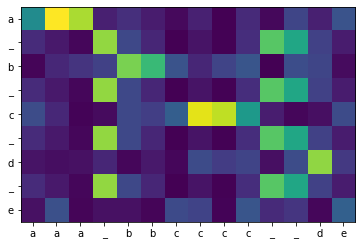

In [0]:
# Show input scores
show(match.transpose(1,2).exp()[0])

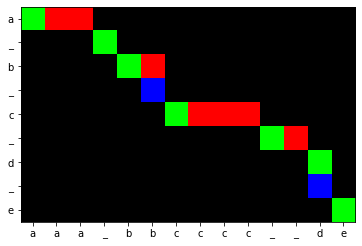

In [0]:
# Find best alignment
dist = torch_struct.AlignmentCRF(log_potentials)
show(dist.argmax[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


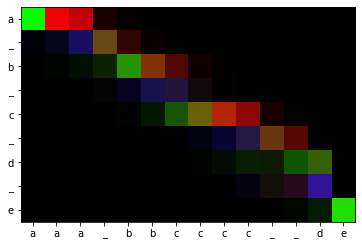

In [0]:
# Find marginals (see uncertainty from randomness)
show(dist.marginals[0])

In [0]:
# Print the log sum exp of the data (for training)
print(dist.partition)

tensor([28.5271, 28.8374, 28.3810, 27.0438, 26.3049], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
